In [1]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import time

In [2]:
first = time.clock()

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [3]:
def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

In [4]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [5]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.5f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

In [6]:
# target = 'target'
# sf = datasets.fetch_kddcup99(subset='SF', percent10=False)
# dfSF=pd.DataFrame(sf.data, 
#                   columns=["duration", "service", "src_bytes", "dst_bytes"])
# assert len(dfSF)>0, "SF dataset no loaded."

# dfSF[target]=sf.target
# anomaly_rateSF = 1.0 - len(dfSF.loc[dfSF[target]==b'normal.'])/len(dfSF)

# "SF Anomaly Rate is:"+"{:.1%}".format(anomaly_rateSF)

In [7]:
# 手动添加特征，训练集42，测试集41

feather = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 
           'num_failed_logins', 'logged_in', 'lnum_compromised', 'lroot_shell', 'lsu_attempted', 'lnum_root', 'lnum_file_creations', 
           'lnum_shells', 'lnum_access_files', 'lnum_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 
           'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 
           'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 
           'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

In [8]:
# TRAIN_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\UNSW-NB 15\\UNSW_NB15_training-set.csv'
TRAIN_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\kddcup\\train_10_percent_kddcup.csv'
TEST_DATA_PATH = 'C:\\Users\\Qin\\Desktop\\kddcup\\test_10_percent_kddcup.csv'

In [9]:
train_df = pd.read_csv(TRAIN_DATA_PATH, header = None, names = feather)
test_df = pd.read_csv(TEST_DATA_PATH, header = None, names = feather)

C:\Users\Qin\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
train_df = train_df[train_df['service'] == 21]

In [11]:
train_df = train_df[train_df['label'] == 0]
y_label = test_df.iloc[ : , 41 : 42]

In [12]:
# 删除所有分类列
train_df.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
# 删除无标准偏差的列
train_df.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'lsu_attempted', 'lnum_file_creations', 'lnum_outbound_cmds'], axis = 1, inplace = True)

# 删除所有分类列
test_df.drop(['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login', 'label'], axis = 1, inplace = True)
# 删除无标准偏差的列
test_df.drop(['wrong_fragment', 'urgent', 'num_failed_logins', 'lsu_attempted', 'lnum_file_creations', 'lnum_outbound_cmds'], axis = 1, inplace = True)

In [13]:
# train
# 采用主成分分析法对数据进行降维，覆盖原始数据80%的方差
# ｎ＿components：指定希望PCA降维后的特征维度数目
# 最常用的做法是直接指定降维到的维度数目，此时n_components是一个大于等于1的整数。
# 当然，我们也可以指定主成分的方差和所占的最小比例阈值，让PCA类自己去根据样本特征方差来决定降维到的维度数，
# 此时n_components是一个（0，1]之间的数。
pca = PCA(n_components = 0.8)
pca.fit(train_df)

pca_cols = ['PCA_' + str(i) for i in range(pca.n_components_)]
train_df = pd.DataFrame(pca.transform(train_df), columns = pca_cols)
test_df = pd.DataFrame(pca.transform(test_df), columns = pca_cols)

In [14]:
y_labels = pd.Series([0 if i == 0 else 1 for i in y_label['label']])

In [15]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score

In [16]:
clfIF = IsolationForest(max_samples=0.25, random_state=11, n_estimators=100, n_jobs=-1)

In [17]:
start = time.clock()
clfIF.fit(train_df)
end = time.clock()
print('Time : ', (end-start))

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Time :  0.4580989999999998


C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
start = time.clock()
y_pred_if = clfIF.predict(test_df)
end = time.clock()
print('Time : ', (end-start))

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Time :  10.0730664


C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
i = 0
for i in range(0, len(y_pred_if)) :
    if y_pred_if[i] == 1 :
        y_pred_if[i] = 0

In [20]:
i = 0
for i in range(0, len(y_pred_if)) :
    if y_pred_if[i] == -1 :
        y_pred_if[i] = 1

In [21]:
prec, recall, fscore, _ = precision_recall_fscore_support(y_labels, y_pred_if, average="binary")
auc = roc_auc_score(y_labels, y_pred_if)
print(f" Precision = {prec:.5f}")
print(f" Recall    = {recall:.5f}")
print(f" F1-Score  = {fscore:.5f}")
print(f" AUC  = {auc:.5f}")

 Precision = 0.93400
 Recall    = 0.70002
 F1-Score  = 0.80026
 AUC  = 0.74778


In [22]:
confusion_matrix(y_labels, y_pred_if)

array([[ 48204,  12389],
       [ 75126, 175310]], dtype=int64)

In [23]:
(48204 + 175310) / len(y_labels)

0.7186275234785181

In [24]:
second = time.clock()

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [25]:
print('time : ', (second - first))

time :  13.9961658


In [26]:
third = time.clock()

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [27]:
clfLOF = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm='auto', contamination=0.15, n_jobs=-1, novelty = True)

In [28]:
start = time.clock()
y_pred_lof = clfLOF.fit(train_df)
end = time.clock()
print('Time : ', (end-start))

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Time :  0.2469494999999995


C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [29]:
start = time.clock()
y_pred_lof = clfLOF.predict(test_df)
end = time.clock()
print('Time : ', (end-start))

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


Time :  0.6450817999999998


C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [30]:
temp = y_pred_lof

In [31]:
i = 0
for i in range(0, len(y_pred_lof)) :
    if y_pred_lof[i] == 1 :
        y_pred_lof[i] = 0

In [32]:
i = 0
for i in range(0, len(y_pred_lof)) :
    if y_pred_lof[i] == -1 :
        y_pred_lof[i] = 1

In [33]:
prec, recall, fscore, _ = precision_recall_fscore_support(y_labels, y_pred_lof, average="binary")
auc = roc_auc_score(y_labels, y_pred_lof)
print(f" Precision = {prec:.5f}")
print(f" Recall    = {recall:.5f}")
print(f" F1-Score  = {fscore:.5f}")
print(f" AUC  = {auc:.5f}")

 Precision = 0.93101
 Recall    = 0.92797
 F1-Score  = 0.92949
 AUC  = 0.82189


In [34]:
confusion_matrix(y_labels, y_pred_lof)

array([[ 43373,  17220],
       [ 18038, 232398]], dtype=int64)

In [35]:
(43373 + 232398) / len(y_labels)

0.8866407955528263

In [36]:
second = time.clock()

C:\Users\Qin\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """Entry point for launching an IPython kernel.


In [37]:
print('time : ', (second - third))

time :  1.7829572999999996


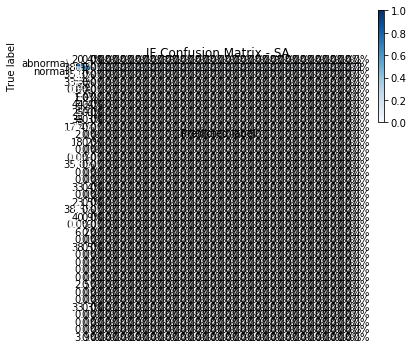

In [38]:
# print(classification_report(y_label, y_pred_if, target_names=['anomaly', 'normal']))
# print ("AUC: ", "{:.5%}".format(roc_auc_score(y_label, y_pred_if)))
cm = confusion_matrix(y_label, y_pred_if)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SA", save=True, saveas="IF_SA.png")

In [39]:
print(classification_report(y_train_nd, y_pred_train_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_nd, y_pred_train_lof)))
cm = confusion_matrix(y_train_nd, y_pred_train_lof)
plot_confusion_matrix(cm, title="LOF Confusion Matrix - SA")

NameError: name 'y_train_nd' is not defined

In [ ]:
# X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(dfSF.drop([target, 'binary_target'], axis=1), 
#                                                                 dfSF['binary_target'], test_size=0.33, random_state=11)
# X_train_nd, X_test_nd, y_train_nd, y_test_nd = train_test_split(dfSF_normed, dfSF['binary_target'], 
#                                                     test_size=0.33, random_state=11)

In [ ]:
# clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_estimators=100, n_jobs=-1)
# clfLOF = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm = 'auto', contamination=0.15, n_jobs=-1)

In [ ]:
# start = datetime.datetime.now()
# clfIF.fit(X_train_sf,y_train_sf)
# y_pred_train = clfIF.predict(X_train_sf)
# end = datetime.datetime.now()
# print (end-start)

In [ ]:
# start = datetime.datetime.now()
# y_pred_train_lof = clfLOF.fit_predict(X_train_nd,y_train_nd)
# end = datetime.datetime.now()
# print (end-start)

In [ ]:
# print(classification_report(y_train_sf, y_pred_train, target_names=['anomaly', 'normal']))
# print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sf, y_pred_train)))
# cm = confusion_matrix(y_train_sf, y_pred_train)
# plot_confusion_matrix(cm, title="IF Confusion Matrix - SF", save=True, saveas="IF_SF.png")

In [ ]:
# print(classification_report(y_train_nd, y_pred_train_lof, target_names=['anomaly', 'normal']))
# print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_nd, y_pred_train_lof)))
# cm = confusion_matrix(y_train_nd, y_pred_train_lof)
# plot_confusion_matrix(cm, title="LOF Confusion Matrix - SF")

In [ ]:
clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_estimators=100, n_jobs=-1)

clfIF.fit(X_train_sa,y_train_sa)
y_pred_test = clfIF.predict(X_test_sa)

print(classification_report(y_test_sa, y_pred_test, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sa, y_pred_test)))
cm = confusion_matrix(y_test_sa, y_pred_test)
plot_confusion_matrix(cm, title="IF Confusion Matrix - SA", save=True, saveas="IF_SA_Test.png")

In [ ]:
# clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_estimators=100, n_jobs=-1)

# clfIF.fit(X_train_sf,y_train_sf)
# y_pred_test = clfIF.predict(X_test_sf)

# print(classification_report(y_test_sf, y_pred_test, target_names=['anomaly', 'normal']))
# print ("AUC: ", "{:.1%}".format(roc_auc_score(y_test_sf, y_pred_test)))
# cm = confusion_matrix(y_test_sf, y_pred_test)
# plot_confusion_matrix(cm, title="IF Confusion Matrix - SF", save=True, saveas="IF_SF_Test.png")

In [ ]:
scoring = {'AUC': 'roc_auc', 'Recall': make_scorer(recall_score, pos_label=-1)}

In [ ]:
gs = GridSearchCV(IsolationForest(max_samples=0.25, random_state=11, contamination = 0.15, n_jobs=-1),
                  param_grid={'n_estimators': range(20, 230, 30)},
                  scoring=scoring, refit='Recall')
gs.fit(X_train_sa, y_train_sa)
results = gs.cv_results_

In [ ]:
plot_gridsearch_cv(results, "n_estimators", 0, 230, 0.73, 1.05, save=True, saveas="GS_n_est.png")

In [ ]:
gs_ms = GridSearchCV(IsolationForest(random_state=11, contamination = 0.15, n_estimators=150, n_jobs=-1),
                  param_grid={'max_samples': np.arange(0.1, 1.0, 0.1)},
                  scoring=scoring, refit='Recall')
gs_ms.fit(X_train_sa, y_train_sa)
results = gs_ms.cv_results_

In [ ]:
plot_gridsearch_cv(results, "max_samples", 0, 1, 0.73, 1.05, save=True, saveas="GS_max_samples.png")

In [ ]:
gs_cont = GridSearchCV(IsolationForest(random_state=11, max_samples=0.10, n_estimators=150, n_jobs=-1),
                  param_grid={'contamination': np.arange(0.01, 0.25, 0.05)},
                  scoring=scoring, refit='Recall')
gs_cont.fit(X_train_sf, y_train_sf)
results = gs_cont.cv_results_

In [ ]:
plot_gridsearch_cv(results, "contamination", 0, 0.20, 0.80, 1.08, save=True, saveas="GS_cont.png")